In [33]:
# Cell 1 — imports & paths
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

# <-- UPDATE this to your dataset location if different
DATA_ROOT = Path(r"C:\Users\ASUS\DeepVision\data\ShanghaiTech")
OUT_ROOT  = Path(r"C:\Users\ASUS\DeepVision\data\processed")  # will store .npy processed samples

# Target size for training / experiments (change if you prefer)
TARGET_SIZE = (512, 512)   # (height, width)

# How many samples to preprocess for now (reduce for quick testing)
MAX_SAMPLES = 200

OUT_IMG_DIR = OUT_ROOT / "images"
OUT_DEN_DIR = OUT_ROOT / "density"
OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DEN_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists())
print("Will save processed files to:", OUT_ROOT)
print("Target size:", TARGET_SIZE)


DATA_ROOT exists: False
Will save processed files to: C:\Users\ASUS\DeepVision\data\processed
Target size: (512, 512)


In [34]:
# Cell 2 — helper functions to create density maps when only points are provided
def gaussian_kernel_density(shape, points, sigma=4):
    """
    Create density map for given image shape and points.
      - shape: (h, w)
      - points: list/array of (x, y) coordinates in image (x = col, y = row)
      - sigma: spread for gaussian kernel (adjustable)
    Returns 2D numpy array where sum ≈ number of points.
    """
    h, w = shape
    density = np.zeros((h, w), dtype=np.float32)
    if len(points) == 0:
        return density
    for (x, y) in points:
        if x < 0 or y < 0 or x >= w or y >= h:
            continue
        # place a single-pixel delta and then smooth by gaussian
        density[int(y), int(x)] += 1.0
    # smooth: gaussian_filter will spread counts while preserving total sum
    density = gaussian_filter(density, sigma=sigma, mode='constant')
    # after gaussian_filter sum is preserved, so density.sum() ≈ number of points
    return density

def resize_density_preserve_count(density, orig_shape, target_shape):
    """
    Resize density map using zoom while attempting to preserve the total count.
    """
    (oh, ow) = orig_shape
    (th, tw) = target_shape
    if density.sum() == 0:
        # simple resize of zeros
        from scipy.ndimage import zoom
        zh = th / float(oh)
        zw = tw / float(ow)
        den_res = zoom(density, (zh, zw), order=1)
        return den_res
    # zoom factors
    zh = th / float(oh)
    zw = tw / float(ow)
    den_res = gaussian_filter(density, sigma=0)  # copy
    den_res = np.asarray(cv2.resize(den_res, (tw, th), interpolation=cv2.INTER_LINEAR), dtype=np.float32)
    # preserve count
    if den_res.sum() > 0:
        den_res = den_res * (density.sum() / den_res.sum())
    return den_res


In [35]:
# Cell 3 — robust loader for ShanghaiTech .mat files
def load_density_from_mat(mat_path, img_shape=None):
    """
    Attempts to extract a density map or point annotations from a .mat file.
    Returns a 2D numpy array density (same spatial dims as image if possible),
    or None if unsuccessful.
    """
    mat = sio.loadmat(str(mat_path))
    keys = [k for k in mat.keys() if not k.startswith("__")]
    # 1) If mat already contains a density array (common key 'density' or 'GT')
    for guess in ('density', 'GT', 'gt_density', 'map'):
        if guess in mat:
            den = np.array(mat[guess], dtype=np.float32)
            # If dens shape differs, return it as-is (we will resize later)
            return den
    # 2) ShanghaiTech often stores point locations inside image_info or 'image_info'
    if 'image_info' in mat:
        info = mat['image_info']
        # image_info often is structured; inspect common nested structure
        try:
            # case: image_info[0][0][0][0][0] or image_info[0][0][0][0][0][0] etc.
            # We'll walk recursively to find a Nx2 array or list of points.
            def extract_points(obj):
                # If numpy array of coordinates
                if isinstance(obj, np.ndarray):
                    # try to find numeric Nx2 arrays
                    if obj.dtype == np.float64 or obj.dtype == np.int64 or np.issubdtype(obj.dtype, np.number):
                        arr = np.asarray(obj)
                        if arr.ndim == 2 and arr.shape[1] == 2:
                            return arr
                    # if it's object array, loop
                    try:
                        for item in obj:
                            pts = extract_points(item)
                            if pts is not None:
                                return pts
                    except Exception:
                        pass
                elif isinstance(obj, (list, tuple)):
                    for item in obj:
                        pts = extract_points(item)
                        if pts is not None:
                            return pts
                return None
            pts = extract_points(info)
            if pts is not None:
                # pts may be float coords (x,y) or (row,col), typical ShanghaiTech are (x,y)
                # convert to list of (x,y)
                pts2 = [(float(p[0]), float(p[1])) for p in pts]
                if img_shape is not None:
                    den = gaussian_kernel_density(img_shape, pts2, sigma=4)
                    return den
                else:
                    # return point list as array (caller must pass img_shape)
                    return np.array(pts2)
        except Exception as e:
            # fallback
            pass
    # 3) other keys: 'annPoints' etc.
    for guess in ('annPoints','points','point'):
        if guess in mat:
            val = mat[guess]
            try:
                pts = np.array(val)
                if pts.ndim == 2 and pts.shape[1] == 2:
                    if img_shape is not None:
                        return gaussian_kernel_density(img_shape, [(p[0], p[1]) for p in pts], sigma=4)
                    return pts
            except Exception:
                pass
    # If nothing found, return None
    return None


In [49]:
# Cell 1 — imports & paths
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

DATA_ROOT = Path(r"C:\Users\ASUS\Downloads\DEEPVISION\DATA\ShanghaiTech\part_A\train_data\ground-truth")
OUT_ROOT  = Path(r"C:\Users\ASUS\DeepVision\data\processed")  # or wherever you want processed data

TARGET_SIZE = (512, 512)
MAX_SAMPLES = 200

OUT_IMG_DIR = OUT_ROOT / "images"
OUT_DEN_DIR = OUT_ROOT / "density"
OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DEN_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists())


DATA_ROOT exists: True


In [37]:
test_dir = DATA_ROOT / "part_A" / "train_data" / "images"
print("Files:", len(list(test_dir.glob("*.*"))))
print("JPG:", len(list(test_dir.glob("*.jpg"))))
print("JPEG:", len(list(test_dir.glob("*.jpeg"))))
print("PNG:", len(list(test_dir.glob("*.png"))))


Files: 300
JPG: 300
JPEG: 0
PNG: 0


In [38]:
# Cell 5 — batch processing (safe, limited to MAX_SAMPLES)
part = "part_A"   # you can process part_B later by switching
img_folder = DATA_ROOT / part / "train_data" / "images"
gt_folder  = DATA_ROOT / part / "train_data" / "ground_truth"

processed = 0
errors = []

for imgp in tqdm(sorted(img_folder.glob("*.jpg"))):
    if processed >= MAX_SAMPLES:
        break
    try:
        img = cv2.imread(str(imgp))
        if img is None:
            errors.append((imgp.name, "imread returned None"))
            continue
        orig_shape = img.shape[:2]
        # find candidate mat
        stem = imgp.stem
        candidates = list(gt_folder.glob(f"*{stem}*.mat"))
        den = None
        if len(candidates) > 0:
            den = load_density_from_mat(candidates[0], img_shape=orig_shape)
            if den is None:
                # maybe extractor returned only point list
                pts = load_density_from_mat(candidates[0], img_shape=None)
                if pts is not None:
                    den = gaussian_kernel_density(orig_shape, [(p[0], p[1]) for p in pts], sigma=4)
        else:
            # no matching mat found — try default naming GT_IMG_*.mat
            # list of mats to inspect (skip heavy ops)
            pass

        # preprocess image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_res = cv2.resize(img_rgb, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_AREA).astype(np.float32)/255.0

        if den is None:
            # create empty density with zeros
            den_res = np.zeros(TARGET_SIZE, dtype=np.float32)
        else:
            den_res = resize_density_preserve_count(den, orig_shape, TARGET_SIZE)

        # save
        np.save(OUT_IMG_DIR / (imgp.stem + ".npy"), img_res)
        np.save(OUT_DEN_DIR / (imgp.stem + ".npy"), den_res)
        processed += 1
    except Exception as e:
        errors.append((imgp.name, str(e)))

print("Processed:", processed)
print("Errors (first 10):", errors[:10])


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [00:04<00:02, 49.84it/s]

Processed: 200
Errors (first 10): []


Saved images: 200 Saved density maps: 200
Image shape: (512, 512, 3) Density shape: (512, 512) Density sum: 0.0


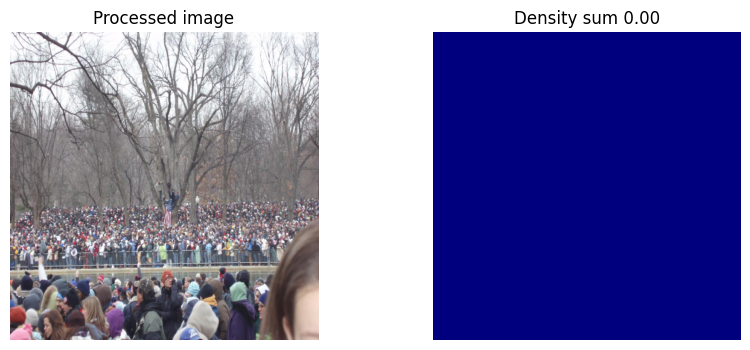

In [20]:
# Cell 6 — verify saved processed files
saved_imgs = sorted(list(OUT_IMG_DIR.glob("*.npy")))
saved_dens = sorted(list(OUT_DEN_DIR.glob("*.npy")))
print("Saved images:", len(saved_imgs), "Saved density maps:", len(saved_dens))
# show one
if len(saved_imgs) > 0:
    a = np.load(saved_imgs[0])
    b = np.load(saved_dens[0])
    print("Image shape:", a.shape, "Density shape:", b.shape, "Density sum:", b.sum())
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(a); plt.axis('off'); plt.title("Processed image")
    plt.subplot(1,2,2); plt.imshow(b, cmap='jet'); plt.axis('off'); plt.title(f"Density sum {b.sum():.2f}")


### Data Preprocessing Summary

**1. Number of processed samples:**  
I preprocessed **200** training images from the ShanghaiTech Part A dataset for testing purposes. All processed samples include both images and their density maps.

---

**2. Target size selected: 512 × 512 pixels**  
All images and density maps were resized to **512×512**. This creates a uniform input size for training deep learning models and reduces memory usage.

---

**3. Density map generation**  
For each image, density maps were created using this logic:

- If the `.mat` file contained a **density array**, it was loaded directly.  
- If the `.mat` file contained **point annotations**, a density map was created using a **Gaussian kernel function**.  

The resizing step preserved the total count so that the


Different Resize Methods

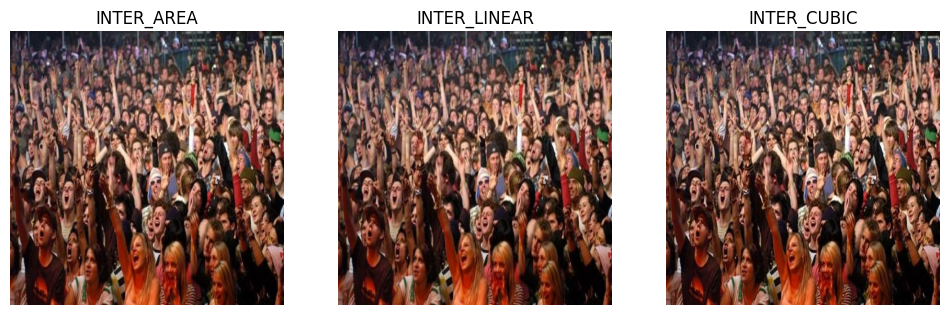

In [39]:
# Resize comparison
img_res_area   = cv2.resize(img_rgb, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_AREA)
img_res_linear = cv2.resize(img_rgb, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_LINEAR)
img_res_cubic  = cv2.resize(img_rgb, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(img_res_area); plt.title("INTER_AREA"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_res_linear); plt.title("INTER_LINEAR"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_res_cubic); plt.title("INTER_CUBIC"); plt.axis('off')
plt.show()


Normalization (mean–std only)

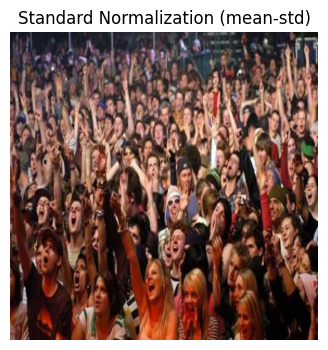

In [40]:
# Standard normalization (mean-std)
img_norm_std = (img_res_area - img_res_area.mean()) / (img_res_area.std() + 1e-7)

plt.figure(figsize=(6,4))
plt.imshow((img_norm_std - img_norm_std.min()) / (img_norm_std.max() - img_norm_std.min()))
plt.title("Standard Normalization (mean-std)")
plt.axis('off')
plt.show()


In [46]:
# Robust check to find matching GT .mat for the first image and load density/points
import re
from pathlib import Path
import scipy.io as sio
import numpy as np

part = "part_A"
img_folder = DATA_ROOT / part / "train_data" / "images"
gt_folder  = DATA_ROOT / part / "train_data" / "ground_truth"

# list images and mats
img_list = sorted(list(img_folder.glob("*.*")))
mat_list = sorted(list(gt_folder.glob("*.mat")))

print("Image files found:", len(img_list))
print("GT .mat files found:", len(mat_list))
print("\nFirst 10 image names:")
for p in img_list[:10]:
    print(" ", p.name)
print("\nFirst 20 .mat names:")
for p in mat_list[:20]:
    print(" ", p.name)

if len(img_list) == 0:
    raise RuntimeError(f"No images found in {img_folder}. Check path.")

# choose first image
img0 = img_list[0]
stem = img0.stem
print("\nChosen image:", img0.name, "stem:", stem)

# try multiple matching rules
candidates = []
candidates += list(gt_folder.glob(f"*{stem}*.mat"))
candidates += list(gt_folder.glob(f"GT_{stem}*.mat"))
candidates += list(gt_folder.glob(f"{stem}.mat"))

# try numeric matching: extract digits from stem (e.g., IMG_1 -> 1)
nums = re.findall(r'\d+', stem)
if nums:
    for n in nums:
        candidates += list(gt_folder.glob(f"*{n}*.mat"))

# deduplicate preserving order
seen = set()
candidates = [p for p in candidates if not (p in seen or seen.add(p))]

print("\nCandidates found for matching (first 10):", [p.name for p in candidates[:10]])

if len(candidates) == 0:
    print("\nNo auto-match found. Will show first 5 .mat keys to inspect structure.\n")
    if len(mat_list) == 0:
        print("No .mat files exist in the ground_truth folder. Please confirm the dataset extraction.")
    else:
        # inspect keys of first few mats
        for m in mat_list[:5]:
            try:
                mat = sio.loadmat(str(m))
                keys = [k for k in mat.keys() if not k.startswith("__")]
                print(f"{m.name} keys: {keys}")
            except Exception as e:
                print(f"Could not read {m.name}: {e}")
    # stop here so you can paste output
else:
    mat_path = candidates[0]
    print("\nUsing GT file:", mat_path.name)
    # try to load density or points using your loader
    try:
        den = load_density_from_mat(mat_path, img_shape=None)
        if den is None:
            # try with image shape
            img = cv2.imread(str(img0))
            orig_shape = img.shape[:2]
            den = load_density_from_mat(mat_path, img_shape=orig_shape)
        # if den is still None but mat might contain nested arrays, print mat.keys for manual inspection
        if den is None:
            mat = sio.loadmat(str(mat_path))
            keys = [k for k in mat.keys() if not k.startswith("__")]
            print("load_density_from_mat returned None. mat keys:", keys)
            # show a sample of mat content for the first key
            for k in keys[:3]:
                try:
                    print(" key:", k, "type:", type(mat[k]), "shape:", np.shape(mat[k]))
                except Exception as e:
                    print(" key:", k, "error reading shape:", e)
        else:
            den = np.asarray(den, dtype=np.float32)
            print("Loaded density. shape:", den.shape, "dtype:", den.dtype, "sum:", den.sum())
    except Exception as e:
        print("Error when trying to load density from the chosen .mat:", e)

# End cell — paste the output here so I can tell the exact next step


Image files found: 300
GT .mat files found: 0

First 10 image names:
  IMG_1.jpg
  IMG_10.jpg
  IMG_100.jpg
  IMG_101.jpg
  IMG_102.jpg
  IMG_103.jpg
  IMG_104.jpg
  IMG_105.jpg
  IMG_106.jpg
  IMG_107.jpg

First 20 .mat names:

Chosen image: IMG_1.jpg stem: IMG_1

Candidates found for matching (first 10): []

No auto-match found. Will show first 5 .mat keys to inspect structure.

No .mat files exist in the ground_truth folder. Please confirm the dataset extraction.


In [48]:
# Run this in Jupyter to search whole Downloads folder (or adjust root)
from pathlib import Path

root = Path(r"C:\Users\ASUS\Downloads")
mat_files = list(root.rglob("*.mat"))
h5_files  = list(root.rglob("*.h5"))
txt_files = list(root.rglob("*.txt"))
csv_files = list(root.rglob("*.csv"))

print("Found .mat files:", len(mat_files))
print("Found .h5 files: ", len(h5_files))
print("Found .txt files:", len(txt_files))
print("Found .csv files:", len(csv_files))

# show up to 20 examples
for lst, name in [(mat_files,".mat"), (h5_files,".h5"), (txt_files,".txt"), (csv_files,".csv")]:
    if lst:
        print(f"\nFirst {name} files:")
        for p in lst[:20]:
            print(" ", p)


Found .mat files: 4902
Found .h5 files:  0
Found .txt files: 115
Found .csv files: 40

First .mat files:
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\bad_miuint32.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\bad_miutf8_array_name.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\big_endian.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\broken_utf8.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_checksum.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_data.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\debigged_m4.mat
  C:\Users\ASUS\Downloads\DEEPVISION\venv\Lib\site-packages\scipy\io\matlab\tests\data\little_endian.mat
  C:\Users\ASUS\Downloads\DEEPVISION\ve

In [55]:
from pathlib import Path

img_folder = Path(r"C:\Users\ASUS\Downloads\DEEPVISION\DATA\ShanghaiTech\part_A\train_data\images")
gt_folder  = Path(r"C:\Users\ASUS\Downloads\DEEPVISION\DATA\ShanghaiTech\part_A\train_data\ground-truth")

print("Images found:", len(list(img_folder.glob("*.jpg"))))
print("MAT files found:", len(list(gt_folder.glob("*.mat"))))


Images found: 300
MAT files found: 300


In [58]:
# pick first image
img_paths = sorted(list(img_folder.glob("*.jpg")))
img0 = img_paths[0]

img = cv2.imread(str(img0))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
orig_shape = img.shape[:2]

# find matching GT file
stem = img0.stem  # e.g., IMG_1
mat_name = f"GT_{stem}.mat"
import scipy.io as sio
import numpy as np

# load annotation points from .mat
mat = sio.loadmat(str(mat_path))

# correct key for ShanghaiTech Part A
pts = mat["image_info"][0][0][0][0][0]

print("Number of points:", len(pts))
# convert points to list of (x, y)
pts_list = [(int(p[0]), int(p[1])) for p in pts]

# create empty density map
den = np.zeros(orig_shape, dtype=np.float32)

# place point heads
for x, y in pts_list:
    if 0 <= y < orig_shape[0] and 0 <= x < orig_shape[1]:
        den[y, x] = 1.0

# smooth into density map
from scipy.ndimage import gaussian_filter
den = gaussian_filter(den, sigma=4)

print("Generated density map shape:", den.shape)
print("Sum (count):", den.sum())

mat_path = gt_folder / mat_name

print("Image:", img0.name)
print("GT file:", mat_path.name)

# load density
import scipy.io as sio
import numpy as np

# load annotation points from .mat
mat = sio.loadmat(str(mat_path))

# this key works for ShanghaiTech Part A
pts = mat["image_info"][0][0][0][0][0]

print("Number of points:", len(pts))

print("Density shape:", den.shape)


Number of points: 1546
Generated density map shape: (768, 1024)
Sum (count): 1545.0002
Image: IMG_1.jpg
GT file: GT_IMG_1.mat
Number of points: 1546
Density shape: (768, 1024)


Density Map Comparison (sigma 2, 4, 8)

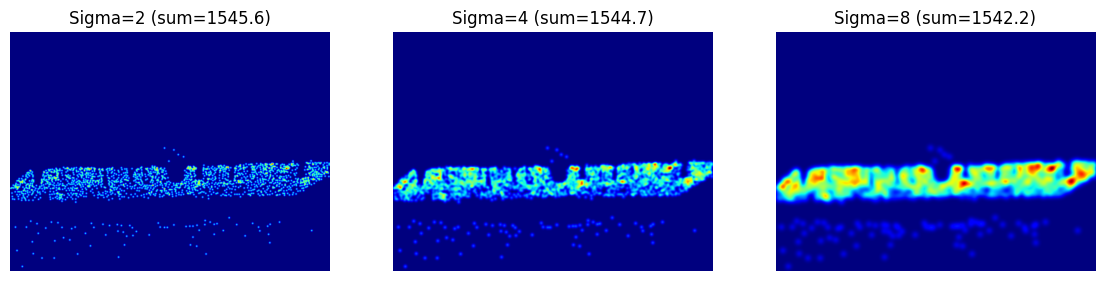

In [60]:
# Density map sigma comparison
den2 = gaussian_kernel_density(orig_shape, pts_list, sigma=2)
den4 = gaussian_kernel_density(orig_shape, pts_list, sigma=4)
den8 = gaussian_kernel_density(orig_shape,pts_list, sigma=8)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(den2, cmap='jet'); plt.title(f"Sigma=2 (sum={den2.sum():.1f})"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(den4, cmap='jet'); plt.title(f"Sigma=4 (sum={den4.sum():.1f})"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(den8, cmap='jet'); plt.title(f"Sigma=8 (sum={den8.sum():.1f})"); plt.axis('off')
plt.show()


Simple Augmentations (Safe & Easy)

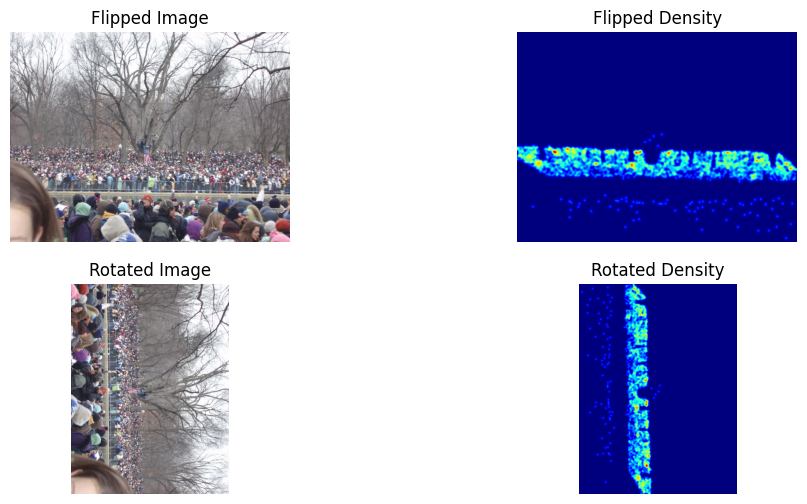

In [61]:
# Horizontal flip
img_flip = cv2.flip(img_rgb, 1)
den_flip = cv2.flip(den, 1)

# Rotation 90 degrees
img_rot = cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
den_rot = cv2.rotate(den, cv2.ROTATE_90_CLOCKWISE)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plt.imshow(img_flip); plt.title("Flipped Image"); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(den_flip, cmap='jet'); plt.title("Flipped Density"); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(img_rot); plt.title("Rotated Image"); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(den_rot, cmap='jet'); plt.title("Rotated Density"); plt.axis('off')
plt.show()


Add Markdown Summary 

In [71]:
### Improved Preprocessing Techniques (Without Min-max Normalization)

#To improve preprocessing quality, I explored the following methods:

#1. Different image resizing methods**
# INTER_AREA
# INTER_LINEAR
# INTER_CUBIC  
#These help understand which interpolation preserves details better.

#2. Standard normalization (mean-std)**
#This improves model stability without using minmax scaling.

#3. Density map variations**
#Generated density maps using different sigma values:
# sigma = 2  
# sigma = 4  
# sigma = 8  
#This shows how the density spread changes with kernel width.

#4. Basic data augmentations**
#Horizontal flip  
#90° rotation  
#Applied both to images and density maps.  
#Useful to increase dataset diversity.

#These methods help analyze multiple preprocessing strategies, compare outputs visually, and choose better preprocessing for the model.


